# Calculate Feature Importance of the Optimal Prediction Approach

For the VM model, get the feature importances for the optimal set of hyperparameters and best performing parameter/feature combination

## Import libraries

In [91]:
import pandas as pd
import seaborn as sns
import math
import os
import matplotlib.pyplot as plt
import glob
import random
from scipy import stats
from pathlib import Path
import warnings
from itertools import product
import joblib
warnings.filterwarnings("ignore") # Will suppress any unnecessary warnings

# ML libraries
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import mean_squared_error, cohen_kappa_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, ConfusionMatrixDisplay
import shap

## Define custom functions

In [92]:
def remove_low_coverage_samples(df_snv_w_cov, min_cov_cutoff, coverage_column):
    """
    Updated to exclude minimum depth requirement.
    Remove iSNVs that do not meet quality control criteria: FAO > 0
        df_snv_w_cov: The dataframe with all SNVs and their features
        min_cov_cutoff: The minimum value for coverage
        coverage_column: The coverage column (FDP or FAO for Ion Torrent data)
    """
    df_snv_high_cov = df_snv_w_cov.copy()
    df_snv_high_cov = df_snv_high_cov.loc[df_snv_high_cov[coverage_column] >= min_cov_cutoff]
    df_snv_high_cov.reset_index(drop=True, inplace=True)
    return df_snv_high_cov
    
def create_balanced_datasets(X_train, y_train, true_label=1, false_label=0):
    """
    Create balanced datasets for training. The test data will remain imbalanced.
        seed_value : The seed for random state selection
        t_size : Size of the test data. Note that this is 30% of the entire data 
                (true label + false label), not 30% of each label. You may notice that 
                the test data for the individual labels (true label or false label) are not exactly 
                30% of the entire data. 
        true_label : The numeric label for the true variants
        false_label: The numeric label for the false variants
    """
    train_samples = {} # Dictionary in which we will store the training samples
    train_index_list = [] # Will keep track of the indices of the sampled rows in the training data.
                          # Depending on the value set for alpha, the number of unique indices
                          # should equal to the size of the training data.
    X_train.reset_index(inplace=True, drop=True)
    
    # If the training data is not balanced, then undersample the over-represented class
    # and create multiple training datasets.
    num_true = y_train.count(true_label) # Number of true labels
    num_false = y_train.count(false_label) # Number of false labels
    
    # Identify the over-represented class 
    if num_true > num_false:
        over_rep_class = true_label
        over_rep_count = num_true
        under_rep_class = false_label
        under_rep_count = num_false
    elif num_false > num_true:
        over_rep_class = false_label
        over_rep_count = num_false
        under_rep_class = true_label
        under_rep_count = num_true
    else:
        # Both classes are balanced
        train_samples['1'] = {}
        train_samples['1']['X_train'] = X_train
        train_samples['1']['y_train'] = y_train
        return train_samples, train_index_list
    
    # # Commenting out this debug info statement for now. Uncomment when needed.
    #print ("\tTrain-test split resulted in imbalanced training data", flush=True)
    #print (f"\tOver-represented class = {over_rep_class}, count = {over_rep_count}", flush=True)
    #print (f"\tUnder-represented class = {under_rep_class}, count = {under_rep_count}", flush=True)
    #print ("\tWill proceed by creating balanced training data.", flush=True)
    
    alpha = 5 # A sampling weight constant that determines the number of times
            # the over-represented class will be sampled.
    num_sample_iter = int(round(over_rep_count/under_rep_count)*alpha)
    sample_size = under_rep_count
    seed_list = list(range(1,num_sample_iter+1)) # The seeds we will use for each iteration of sampling.
                                                 # This is to make the results reproducible.
    # Identify the indices of the over-represented and under-represented class
    # and get the respective data in X_train.
    over_rep_indices = list(np.where(np.array(y_train) == over_rep_class)[0])
    X_train_over_rep = X_train.iloc[over_rep_indices]
    under_rep_indices = list(np.where(np.array(y_train) == under_rep_class)[0])
    X_train_under_rep = X_train.iloc[under_rep_indices]
   
    # Perform sampling
    for seed_i in seed_list:
#         print (f"Sampling iteration {seed_i}...", flush=True, end='')
#         print (sample_size)
#         print (len(X_train_over_rep))
#         print (len(X_train_under_rep))
        X_train_sample_i_over_rep= X_train_over_rep.sample(n=sample_size, replace=False, random_state=seed_i)
        y_train_sample_i_over_rep = [over_rep_class] * sample_size
        # Consolidate the training feature data for the under represented class
        # and over-represented class into a single data frame
        #X_train_sample_i = X_train_sample_i_over_rep.append(X_train_under_rep)
        X_train_sample_i = pd.concat([X_train_sample_i_over_rep, X_train_under_rep])
        
        ind_i_list = X_train_sample_i.index.tolist()
    #     print (ind_i_list)
    #     break
        if len(train_index_list) == 0:
            train_index_list = ind_i_list
        else:    
            train_index_list.extend(ind_i_list)
        
        # Turn off reset index for de-bugging
        X_train_sample_i.reset_index(inplace=True, drop=True)
        # Consolidate the training labels for the under represented
        # and over represented classes
        y_train_sample_i = y_train_sample_i_over_rep  + [under_rep_class] * sample_size
        
        # Shuffle the rows. Otherwise the Top N rows will be over-rep class and 
        # bottom N rows will be under-rep class.
        X_train_sample_i_shuffled = X_train_sample_i.sample(frac=1, random_state=seed_i)
        shuffled_indices = X_train_sample_i_shuffled.index.to_list()
        #
        y_train_sample_i_shuffled = [y_train_sample_i[ind_i] for ind_i in shuffled_indices]
        train_samples[seed_i] = {}
        train_samples[seed_i]['X_train'] = X_train_sample_i_shuffled
        train_samples[seed_i]['y_train'] = y_train_sample_i_shuffled
    return train_samples, train_index_list
 
def get_ensemble_prediction(y_scores_all_models):
    """
    For a given testing point, get the median score across all the models.
    If the median score is >= 0.5, then label 1 else label 0. 
    """
    median_scores = list(y_scores_all_models.median(axis=1))
    median_labels = list(map(lambda x: 0 if (round(x,2) < 0.5) else 1, median_scores))
    return median_labels


def get_ensemble_prediction_scores(y_scores_all_models):
    """
    Return the median scores across all the models for a given test 
    data point.
    """
    median_scores = list(y_scores_all_models.median(axis=1))
    median_scores = [round(score_i,2) for score_i in median_scores]
    return median_scores

## Train VM models with optimal parameters/features and hyperparameters

### Set the output directory, optimal parameter/feature combination and the optimal hyperparameters

In [93]:
## Create output directory
outdir = '../results_01052024_VM_feature_importance/'
Path(outdir).mkdir(parents=True, exist_ok=True)

# The input vcf .csv file
snv_sbs_file = '../data/SNV_data_with_vcf_genie.csv'

# Define parameters that previously showed optimal performance
af_upper = 0.5
feature_cat = 'Moderate'
true_var = 1
false_var = 0.33

# Define feature categories as a dictionary
feat_cat_dict = {'Moderate': ['FSAF','FSAR','FSRF','FSRR','FWDB','FXX','GQ','MLLD','QUAL','REFB',
                'REVB','SAF','SAR','SRF','SRR','SSSB','STB','VARB', '5_PRIME_NUCLEOTIDE_CONTEXT', '3_PRIME_NUCLEOTIDE_CONTEXT'],
                'Strict': ['FSAF','FSAR','FSRF','FSRR','FWDB','FXX','MLLD','QUAL','REFB','REVB','SSSB','VARB', 
                           '5_PRIME_NUCLEOTIDE_CONTEXT', '3_PRIME_NUCLEOTIDE_CONTEXT'],
                'Exhaustive': ['AO','DP','FAO','FDP','FRO','FSAF','FSAR','FSRF','FSRR','FWDB',
                'FXX','GQ','HRUN','LEN','MLLD','QD','QUAL','RBI','REFB','REVB',
                'RO','SAF','SAR','SRF','SRR','SSSB','STB','STBP','VARB', '5_PRIME_NUCLEOTIDE_CONTEXT',
                '3_PRIME_NUCLEOTIDE_CONTEXT']
                }

# Define the optimal hyperparameter values for which we received the best performance - that's hyperparameter ID 2419
eta_opt = 0.2
num_trees_opt = 50
gamma_opt = 0
max_depth_opt = 10
sub_sample_opt = 1
colsample_opt = 0.5
reg_lambda_opt = 2
reg_alpha_opt = 1


### Train the models and get feature importance over all the data

In [94]:
df_snv_sbs = pd.read_csv(snv_sbs_file)

# Create a column to include the sample id (excluding the well id)
df_snv_sbs['sample_id'] = df_snv_sbs['sample'].apply(lambda x: x.split('_')[0])

# Remove variants with FAO = 0
fao_cutoff = 1
df_snv_sbs_fao_filtered = remove_low_coverage_samples(df_snv_sbs, fao_cutoff, 'FAO')

random.seed(10)

# Using the above seed we will select 50 random integers between 1 and 500.
# Using this set seed above will help us generate the same set of random integers
# and make the results reproducible.    
int_list = list(range(1,500))
seed_list = random.sample(int_list, 50)
#seed_list = random.sample(int_list, 1)

# Store the feature importance across all the iterations.
df_feat_imp_all_seeds = pd.DataFrame()
all_shap_values = np.array([])
df_X_train_all_data = pd.DataFrame()
for seed_i in seed_list:
    # We will consider the SNVs in each replicate set only once and perform
    # training and testing for each replicate set independently.
    df_feat_imp_seed_i = pd.DataFrame()

    ## Create output directory
    if not outdir.endswith('/'):
        outdir += '/'

    # Get all the sample IDs
    all_sample_ids = df_snv_sbs_fao_filtered['sample_id'].drop_duplicates().tolist()

    # Set the random sampling seed to seed_i
    random.seed(seed_i)

    # We will pick 6 testing samples and make sure SNVs from these samples
    # are not included in the testing set.
    testing_set_samples = random.sample(all_sample_ids, k=6)
    print (f"testing samples = {testing_set_samples}")
    training_set_samples = [sample_id for sample_id in all_sample_ids if sample_id not in testing_set_samples]

    # Get the SNVs corresponding to the training and testing data
    df_snvs_testing = df_snv_sbs_fao_filtered.loc[df_snv_sbs_fao_filtered['sample_id'].isin(testing_set_samples)]
    df_snvs_training = df_snv_sbs_fao_filtered.loc[~df_snv_sbs_fao_filtered['sample_id'].isin(testing_set_samples)]
    df_snvs_testing.reset_index(drop=True, inplace=True)
    df_snvs_training.reset_index(drop=True, inplace=True)

    # Prepare training and testing data for the given parameter-feature combination
    df_snvs_training_comb_i = df_snvs_training.copy()
    df_snvs_training_comb_i = df_snvs_training_comb_i.loc[(df_snvs_training_comb_i['AF'] < af_upper)]    

    df_snvs_training_comb_i = df_snvs_training_comb_i.loc[(df_snvs_training_comb_i['PERCENT_OVERLAP'] == true_var) | (df_snvs_training_comb_i['PERCENT_OVERLAP'] == false_var)]
    df_snvs_training_comb_i.reset_index(drop=True, inplace=True)
    overlap_cat = list(df_snvs_training_comb_i['PERCENT_OVERLAP'].apply(lambda x: 1 if (x == true_var) else 0 ))

    # Create a binary response column to identify a variant as true variant (1) or false variant (0)
    df_snvs_training_comb_i['OVERLAP_CATEGORY'] = overlap_cat
    target_cols = 'OVERLAP_CATEGORY' # Response column 

    # Note - we do not require a testing dataset for feature importance - so I have skipped the part fetching the SNVs for the testing data.   

    ## Train models and fetch feature importance   
    feature_cols = feat_cat_dict[feature_cat]
    X_train = df_snvs_training_comb_i[feature_cols]
    y_train = df_snvs_training_comb_i[target_cols].tolist()
                                                      
    # Balance the training set
    train_sample, train_index_list = create_balanced_datasets(X_train,y_train)

    xgb_model = XGBClassifier(use_label_encoder=False,
                          booster='gbtree', # boosting algorithm to use, default gbtree, othera: gblinear, dart
                          n_estimators=num_trees_opt, # number of trees, default = 100
                          eta=eta_opt, # this is learning rate, default = 0.3
                          max_depth=max_depth_opt, # maximum depth of the tree, default = 6
                          gamma = gamma_opt, # used for pruning, if gain < gamma the branch will be pruned, default = 0
                          reg_lambda = reg_lambda_opt, # regularization parameter, defautl = 1
                          eval_metric = 'logloss',
                          colsample_bytree = colsample_opt,
                          alpha = reg_alpha_opt,
                          subsample = sub_sample_opt    
                             )
    for model_i in list(train_sample.keys()):
        X_train_model_i = train_sample[model_i]['X_train']
        y_train_model_i = train_sample[model_i]['y_train']
#         print (f"Running CV and predictions for model {model_i}...", end='', flush=True)
        X_train_model_i = X_train_model_i.apply(pd.to_numeric)
        xgb_model.fit(X_train_model_i,y_train_model_i)
        explainer_i = shap.TreeExplainer(xgb_model)
        
        shap_values = explainer_i.shap_values(X_train_model_i)
        #print (f"Length of all shap values = {len(all_shap_values)}")
        #print (f"Length of all training data = {len(df_X_train_all_data)}")
        if len(all_shap_values) == 0:
            all_shap_values = shap_values
        else:
            all_shap_values = np.concatenate((all_shap_values, shap_values))
        df_X_train_all_data = pd.concat([df_X_train_all_data, X_train_model_i])

df_X_train_all_data.reset_index(drop=True, inplace=True)
df_X_train_all_data.rename(columns={'5_PRIME_NUCLEOTIDE_CONTEXT':'5PC', '3_PRIME_NUCLEOTIDE_CONTEXT':'3PC'}, inplace=True)


testing samples = ['sample15', 'sample1', 'sample19', 'sample11', 'sample22', 'sample20']
testing samples = ['sample22', 'sample10', 'sample2', 'sample7', 'sample17', 'sample25']
testing samples = ['sample27', 'sample6', 'sample11', 'sample1', 'sample12', 'sample16']
testing samples = ['sample20', 'sample10', 'sample27', 'sample2', 'sample15', 'sample30']
testing samples = ['sample4', 'sample26', 'sample8', 'sample17', 'sample22', 'sample14']
testing samples = ['sample11', 'sample17', 'sample13', 'sample23', 'sample28', 'sample30']
testing samples = ['sample30', 'sample12', 'sample15', 'sample31', 'sample29', 'sample22']
testing samples = ['sample21', 'sample15', 'sample12', 'sample3', 'sample11', 'sample2']
testing samples = ['sample26', 'sample21', 'sample2', 'sample12', 'sample27', 'sample4']
testing samples = ['sample6', 'sample21', 'sample31', 'sample14', 'sample7', 'sample29']
testing samples = ['sample13', 'sample7', 'sample31', 'sample18', 'sample22', 'sample21']
testing sample

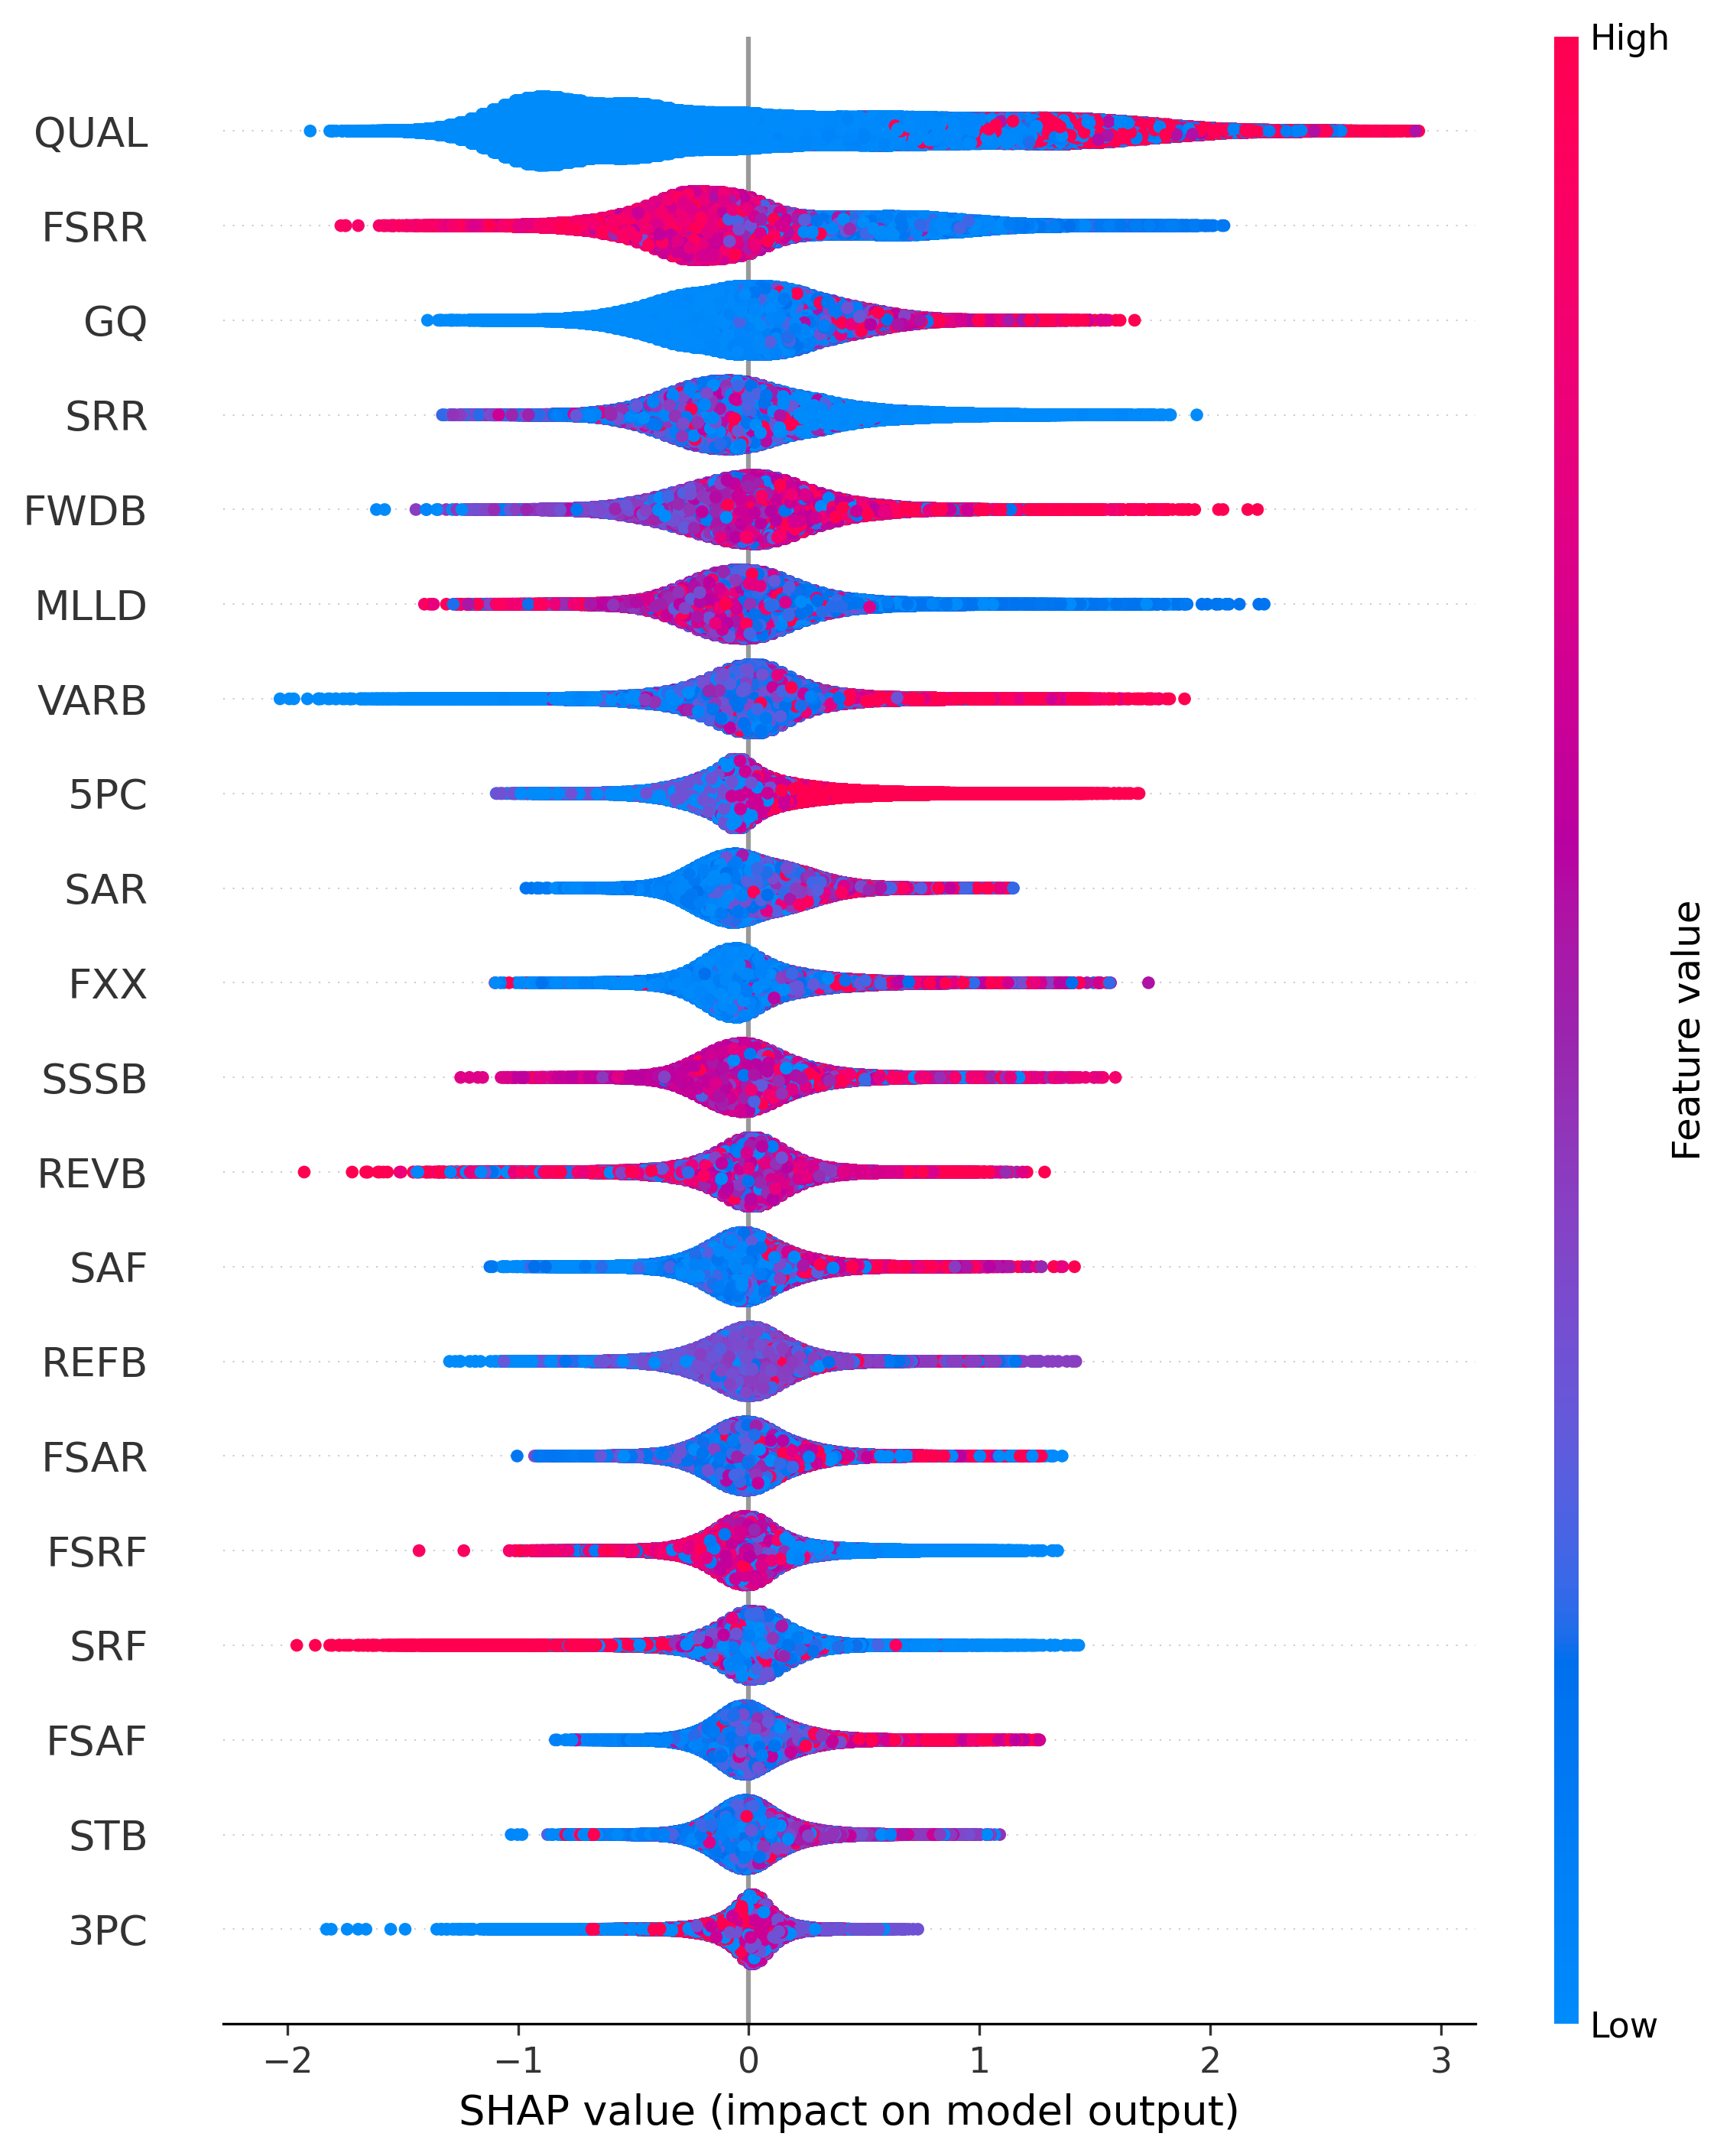

In [95]:
plt.figure(figsize=(10,10), dpi=300)
shap.summary_plot(all_shap_values, df_X_train_all_data, class_names=xgb_model.classes_)
#plt.savefig('../results_01052024_VM_feature_importance/shap_feature_imp.png', dpi=300)
#plt.close()

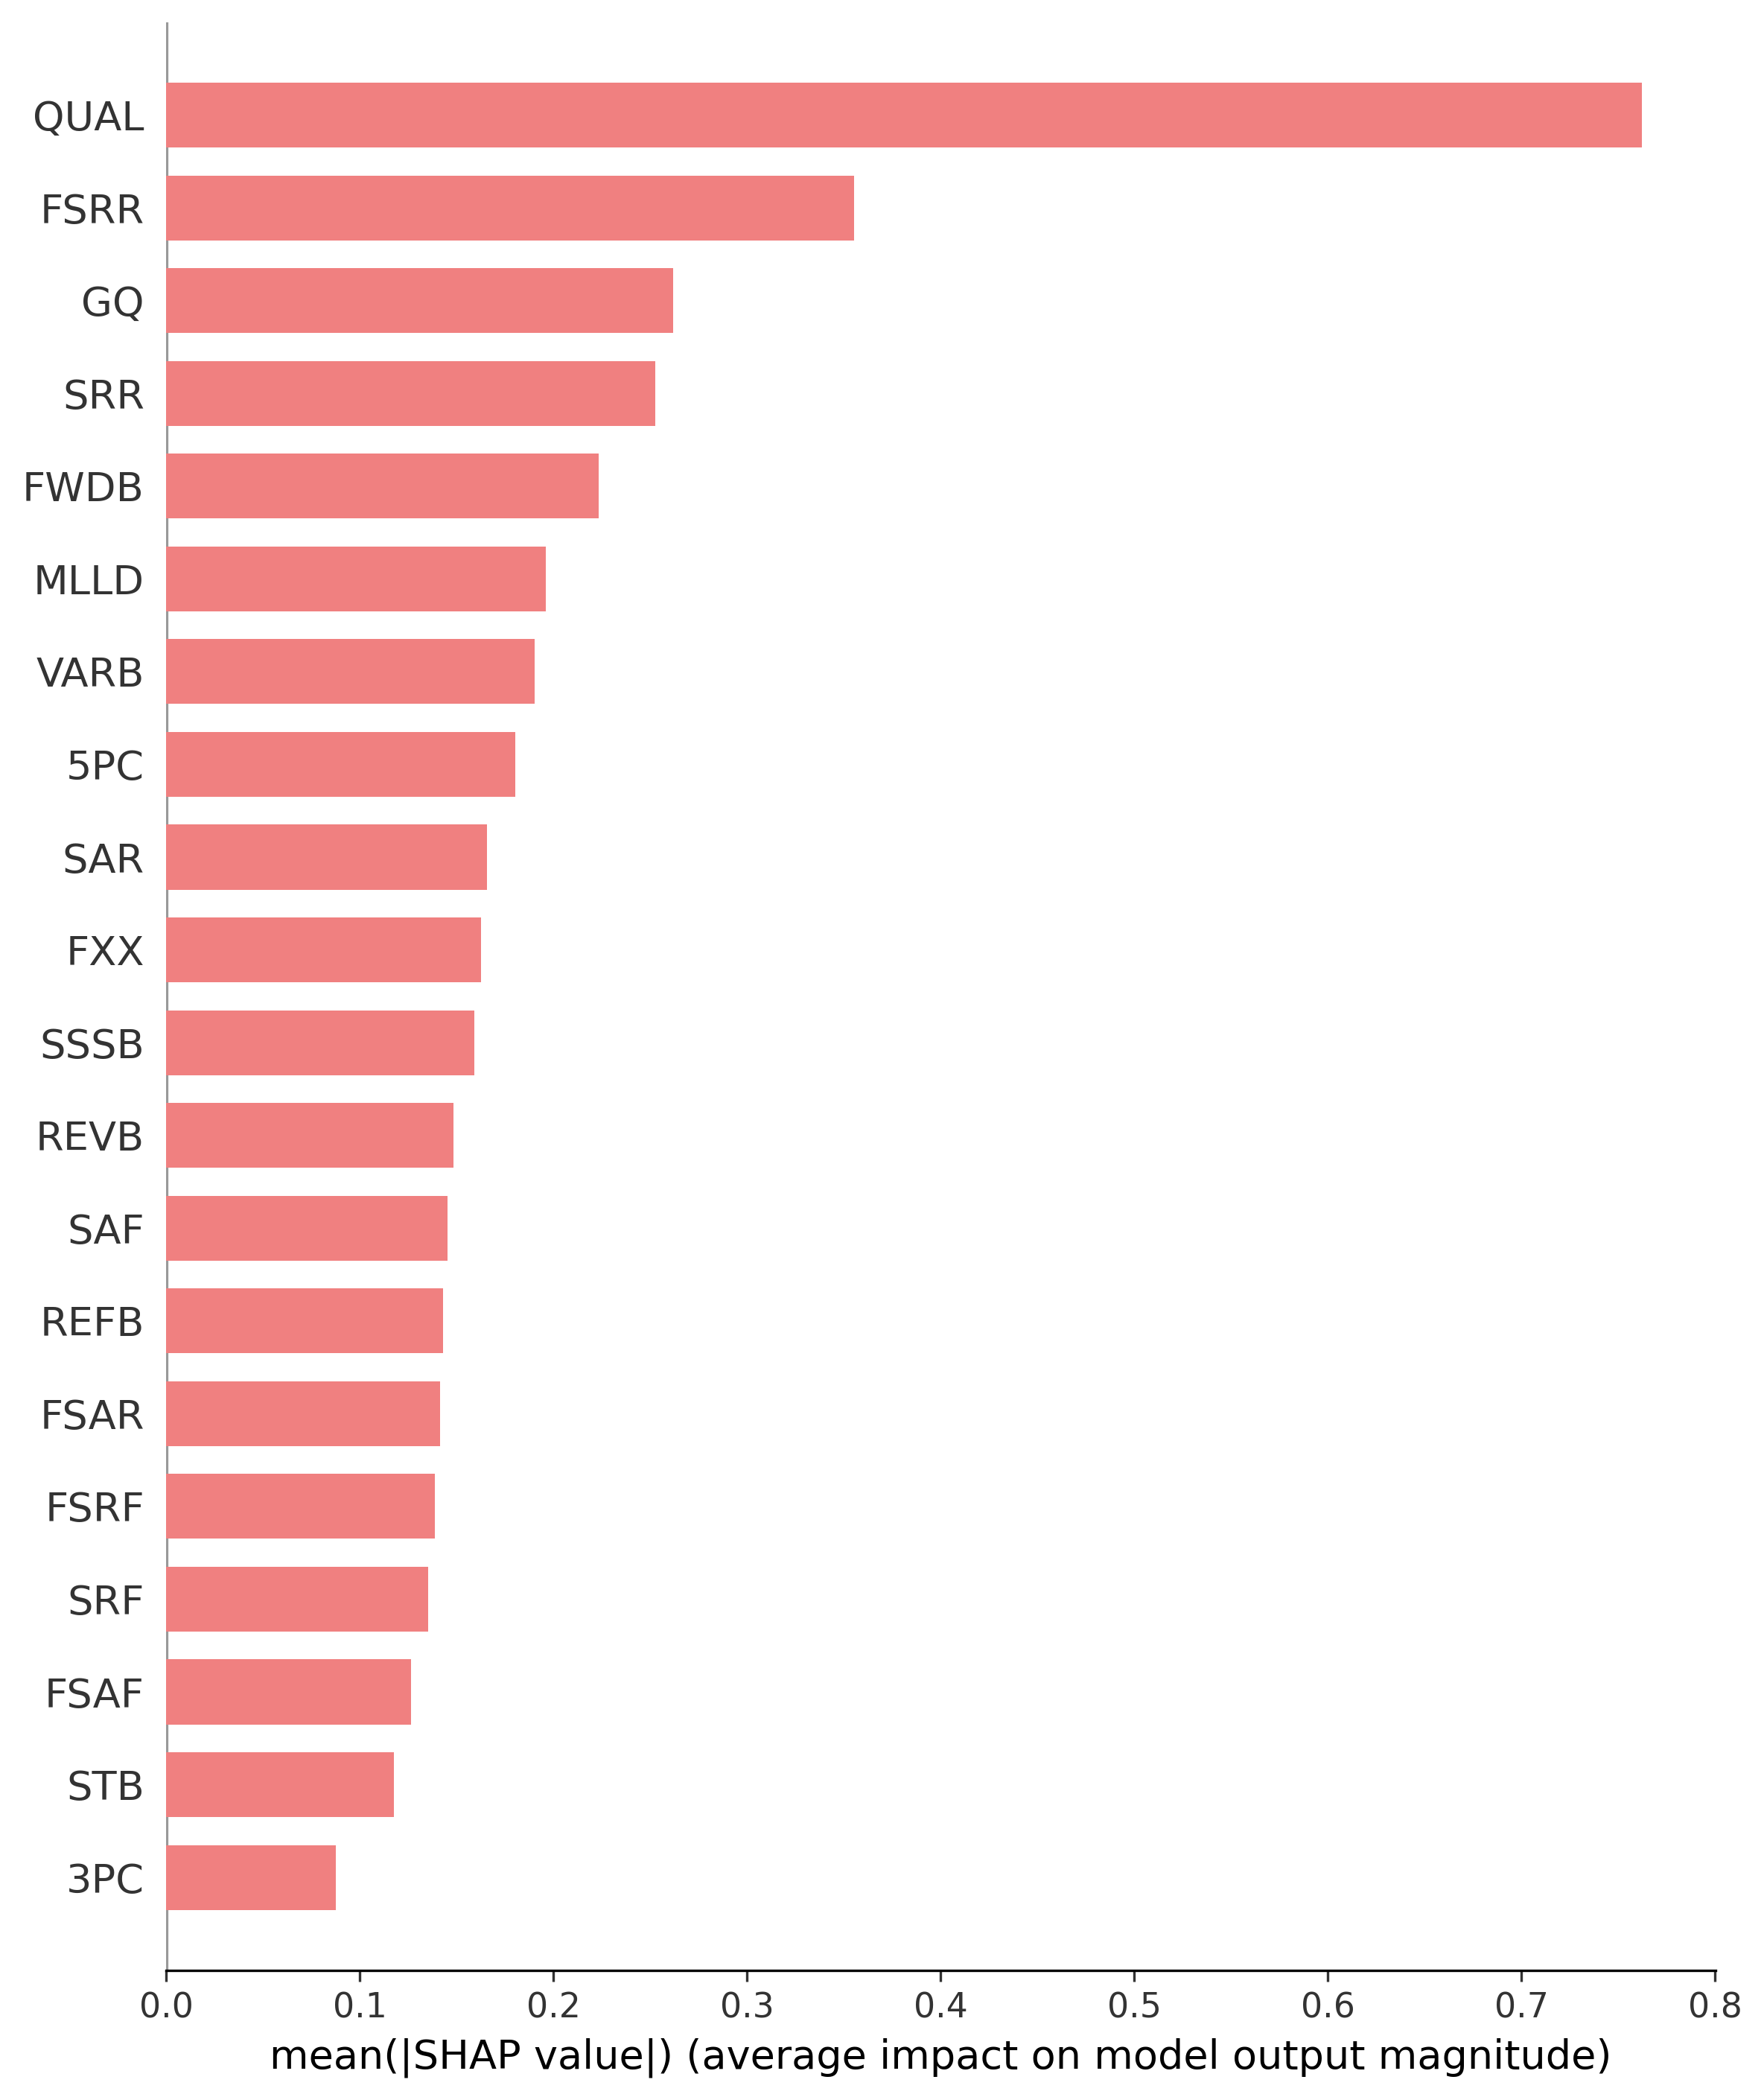

In [96]:

plt.figure(figsize=(10,10), dpi=300)
shap.summary_plot(all_shap_values, df_X_train_all_data, class_names=xgb_model.classes_, plot_type='bar', color='lightcoral')